CONTEXTE : Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

OBJECTIF : vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

NB : Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)


TO DO :
En + : Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.


CONSEILS :
L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données / DATA LEAKS). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

fuite des données ? :

In [261]:
%reset -f

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


### TODO :
1) checker Total GFA = buildingGFA + parking GFA  delete outliers
2) Fill SecondGFA and third GFA / delete outliers
3) List Property : split ??
4) checker natural gas kBtu and kWh and delete one of them
5) outliers delete ? (electricty negative and outliers column)
6) Property tupe (12) to numbers ?? or keep ?? (graph and cross data !!!)
7) Zipcode KNN and replace by correct values
8) outliers check (negative, too big etc)
9) graphs (scatter plots, boxplot, describe, correlation matrix)

### Visualizing dataset

In [262]:
# load raw dataset
#all_data = pd.read_csv("dataset/2016_Building_Energy_Benchmarking.csv", sep = ',', encoding = 'utf-8')
all_data = pd.read_csv("dataset/2016_Building_Energy_Benchmarking.csv")

display(all_data)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00000,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.00000,12,88434,0,88434,Hotel,Hotel,88434.00000,NaN,NaN,NaN,NaN,NaN,60.00000,81.70000,84.30000,182.50000,189.00000,7226362.50000,7456910.00000,2003882.00000,1156514.25000,3946027.00000,12764.52930,1276453.00000,False,NaN,Compliant,NaN,249.98000,2.83000
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00000,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.00000,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00000,Parking,15064.00000,Restaurant,4622.00000,NaN,61.00000,94.80000,97.90000,176.10001,179.39999,8387933.00000,8664479.00000,0.00000,950425.18750,3242851.00000,51450.81641,5145082.00000,False,NaN,Compliant,NaN,295.86000,2.86000
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00000,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.00000,41,956110,196718,759392,Hotel,Hotel,756493.00000,NaN,NaN,NaN,NaN,NaN,43.00000,96.00000,97.70000,241.89999,244.10001,72587024.00000,73937112.00000,21566554.00000,14515435.00000,49526664.00000,14938.00000,1493800.00000,False,NaN,Compliant,NaN,2089.28000,2.19000
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00000,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.00000,10,61320,0,61320,Hotel,Hotel,61320.00000,NaN,NaN,NaN,NaN,NaN,56.00000,110.80000,113.30000,216.20000,224.00000,6794584.00000,6946800.50000,2214446.25000,811525.31250,2768924.00000,18112.13086,1811213.00000,False,NaN,Compliant,NaN,286.43000,4.67000
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00000,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.00000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00000,Parking,68009.00000,Swimming Pool,0.00000,NaN,75.00000,114.80000,118.70000,211.39999,215.60001,14172606.00000,14656503.00000,0.00000,1573448.62500,5368607.00000,88039.98438,8803998.00000,False,NaN,Compliant,NaN,505.01000,2.88000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.00000,1,12294,0,12294,Office,Office,12294.00000,NaN,NaN,NaN,NaN,NaN,46.00000,69.10000,76.70000,161.70000,176.10001,849745.68750,943003.18750,0.00000,153655.00000,524270.86000,3254.75024,325475.02440,True,NaN,Error - Correct Default Data,NaN,20.94000,1.70000
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.00000,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00000,NaN,NaN,NaN,NaN,NaN,NaN,59.40000,65.90000,114.20000,118.90000,950276.18750,1053705.75000,0.00000,116221.00000,396546.05200,5537.29980,553729.98050,False,NaN,Compliant,NaN,32.17000,2.01000
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN

What's in this Dataset?
Rows : 3,376
Columns : 46
Each row is a : Building


source : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [263]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [264]:
# Primary Key : OSEBuilding ID
all_data["OSEBuildingID"].unique().shape

(3376,)

In [265]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
all_data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.00000,3376.00000,3360.00000,3376.00000,3376.00000,3376.00000,3376.00000,3368.00000,3376.00000,3376.00000,3376.00000,3376.00000,3356.00000,1679.00000,596.00000,2533.00000,3369.00000,3370.00000,3367.00000,3367.00000,3371.00000,3370.00000,3367.00000,3367.00000,3367.00000,3367.00000,3367.00000,0.00000,3367.00000,3367.00000
mean,21208.99111,2016.00000,98116.94911,4.43928,47.62403,-122.33480,1968.57316,1.10689,4.70912,94833.53732,8001.52607,86832.01126,79177.63856,28444.07582,11738.67517,67.91867,54.73212,57.03380,134.23285,137.78393,5403667.29453,5276725.71439,274595.89821,1086638.96657,3707612.16159,13685.04538,1368504.54144,NaN,119.72397,1.17592
std,12223.75701,0.00000,18.61520,2.12063,0.04776,0.02720,33.08816,2.10840,5.49446,218837.60712,32326.72393,207939.81192,201703.40749,54392.91793,29331.19929,26.87327,56.27312,57.16333,139.28755,139.10981,21610628.62764,15938786.48412,3912173.39270,4352478.35521,14850656.13896,67097.80830,6709780.83488,NaN,538.83223,1.82145
min,1.00000,2016.00000,98006.00000,1.00000,47.49917,-122.41425,1900.00000,0.00000,0.00000,11285.00000,0.00000,3636.00000,5656.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,-2.10000,0.00000,0.00000,0.00000,-33826.80078,-115417.00000,0.00000,0.00000,NaN,-0.80000,-0.02000
25%,19990.75000,2016.00000,98105.00000,3.00000,47.59986,-122.35066,1948.00000,1.00000,2.00000,28487.00000,0.00000,27756.00000,25094.75000,5000.00000,2239.00000,53.00000,27.90000,29.40000,74.70000,78.40000,925128.59375,970182.23438,0.00000,187422.94535,639487.00000,0.00000,0.00000,NaN,9.49500,0.21000
50%,23112.00000,2016.00000,98115.00000,4.00000,47.61867,-122.33249,1975.00000,1.00000,4.00000,44175.00000,0.00000,43216.00000,39894.00000,10664.00000,5043.00000,75.00000,38.60000,40.90000,96.20000,101.10000,1803753.25000,1904452.00000,0.00000,345129.90630,1177583.00000,3237.53760,323754.00000,NaN,33.92000,0.61000
75%,25994.25000,2016.00000,98122.00000,7.00000,47.65712,-122.31941,1997.00000,1.00000,5.00000,90992.00000,0.00000,84276.25000,76200.25000,26640.00000,10138.75000,90.00000,60.40000,64.27500,143.89999,148.35000,4222455.25000,4381429.12500,0.00000,829317.84375,2829632.50000,11890.33496,1189033.50000,NaN,93.94000,1.37000
max,50226.00000,2016.00000,98272.00000,7.00000,47.73387,-122.22097,2015.00000,111.00000,99.00000,9320156.00000,512608.00000,9320156.00000,9320156.00000,686750.00000,459748.00000,100.00000,834.40002,834.40002,2620.00000,2620.00000,873923712.00000,471613856.00000,134943456.00000,192577488.00000,657074389.00000,2979090.00000,297909000.00000,NaN,16870.98000,34.09000


In [266]:
all_data["ListOfAllPropertyUseTypes"].unique().tolist()

['Hotel',
 'Hotel, Parking, Restaurant',
 'Hotel, Parking, Swimming Pool',
 'Police Station',
 'Other - Entertainment/Public Assembly',
 'Multifamily Housing',
 'Hotel, Parking',
 'Data Center, Library, Parking',
 'Fitness Center/Health Club/Gym, Office, Swimming Pool',
 'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
 'Courthouse',
 'Other',
 'K-12 School',
 'College/University',
 'Automobile Dealership',
 'Hotel, Parking, Retail Store, Swimming Pool',
 'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
 'Self-Storage Facility',
 'Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office',
 'Non-Refrigerated Warehouse, Office, Refrigerated Warehouse',
 'Non-Refrigerated Warehouse, Office',
 'Office, Other - Education',
 'Office, Self-Storage Facility, Vocational School',
 'Data Center, Office, Retail Store',
 'Other - Mall, Personal Services (Health/Beauty, Dry Cleaning, etc)',
 '

In [267]:
all_data["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [268]:
#all_data["PropertyName"].unique()
l = sorted(all_data["PrimaryPropertyType"].unique().tolist())
l

['Distribution Center',
 'High-Rise Multifamily',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket / Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

In [269]:
np.sort(all_data["PrimaryPropertyType"].unique())

array(['Distribution Center', 'High-Rise Multifamily', 'Hospital',
       'Hotel', 'K-12 School', 'Laboratory', 'Large Office',
       'Low-Rise Multifamily', 'Medical Office', 'Mid-Rise Multifamily',
       'Mixed Use Property', 'Office', 'Other', 'Refrigerated Warehouse',
       'Residence Hall', 'Restaurant', 'Retail Store',
       'Self-Storage Facility', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'University', 'Warehouse', 'Worship Facility'], dtype=object)

In [270]:
all_data["City"].unique()
all_data["State"].unique()
#all_data["ZipCode"].unique()
#all_data["CouncilDistrictCode"].unique() # 1 to 7

# Idea : councildistrictcode / neighborhood

a = all_data["Neighborhood"].unique().tolist()


b = [e.lower() for e in a]
b = set(b)
b

b = list(b)
len(b) # 14 après

len(a) # 19 avant:

19

19 unique neighborhoods, but because of upper case / lower case we get 14 neighborhoods.
We will use CouncilDistrictCode to localize the buildings.

### Dropping features / variables

In [271]:
columns_to_drop = ["PropertyName", "Address", "City", "State", "TaxParcelIdentificationNumber", "Neighborhood", "YearsENERGYSTARCertified", "DefaultData", "Comments", "ComplianceStatus"] ###

In [272]:
all_data_v1 = all_data.drop(columns=columns_to_drop)
display(all_data_v1)
# fillNaN for GFA
columns_to_fill = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA", "Outlier"]

all_data_v1[columns_to_fill]





,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,98101.00000,7,47.61220,-122.33799,1927,1.00000,12,88434,0,88434,Hotel,Hotel,88434.00000,NaN,NaN,NaN,NaN,60.00000,81.70000,84.30000,182.50000,189.00000,7226362.50000,7456910.00000,2003882.00000,1156514.25000,3946027.00000,12764.52930,1276453.00000,NaN,249.98000,2.83000
1,2,2016,NonResidential,Hotel,98101.00000,7,47.61317,-122.33393,1996,1.00000,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00000,Parking,15064.00000,Restaurant,4622.00000,61.00000,94.80000,97.90000,176.10001,179.39999,8387933.00000,8664479.00000,0.00000,950425.18750,3242851.00000,51450.81641,5145082.00000,NaN,295.86000,2.86000
2,3,2016,NonResidential,Hotel,98101.00000,7,47.61393,-122.33810,1969,1.00000,41,956110,196718,759392,Hotel,Hotel,756493.00000,NaN,NaN,NaN,NaN,43.00000,96.00000,97.70000,241.89999,244.10001,72587024.00000,73937112.00000,21566554.00000,14515435.00000,49526664.00000,14938.00000,1493800.00000,NaN,2089.28000,2.19000
3,5,2016,NonResidential,Hotel,98101.00000,7,47.61412,-122.33664,1926,1.00000,10,61320,0,61320,Hotel,Hotel,61320.00000,NaN,NaN,NaN,NaN,56.00000,110.80000,113.30000,216.20000,224.00000,6794584.00000,6946800.50000,2214446.25000,811525.31250,2768924.00000,18112.13086,1811213.00000,NaN,286.43000,4.67000
4,8,2016,NonResidential,Hotel,98121.00000,7,47.61375,-122.34047,1980,1.00000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00000,Parking,68009.00000,Swimming Pool,0.00000,75.00000,114.80000,118.70000,211.39999,215.60001,14172606.00000,14656503.00000,0.00000,1573448.62500,5368607.00000,88039.98438,8803998.00000,NaN,505.01000,2.88000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,NaN,2,47.56722,-122.31154,1990,1.00000,1,12294,0,12294,Office,Office,12294.00000,NaN,NaN,NaN,NaN,46.00000,69.10000,76.70000,161.70000,176.10001,849745.68750,943003.18750,0.00000,153655.00000,524270.86000,3254.75024,325475.02440,NaN,20.94000,1.70000
3372,50223,2016,Nonresidential COS,Other,NaN,2,47.59625,-122.32283,2004,1.00000,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00000,NaN,NaN,NaN,NaN,NaN,59.40000,65.90000,114.20000,118.90000,950276.18750,1053705.75000,0.00000,116221.00000,396546.05200,5537.29980,553729.98050,NaN,32.17000,2.01000
3373,50224,2016,Nonresidential COS,Other,NaN,7,47.63644,-122.35784,1974,1.00000,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00000,Fitness Center/Health Club/Gym,5574.00000,Swimming Pool,0.00000,NaN,438.20001,460.10001,744.79999,767.79999,5765898.00000,6053764.50000,0.00000,525251.68750,1792158.75800,39737.39063,3973739.06300,NaN,223.54000,16.99000
3374,50225,2016,Nonresidential COS,Mixed Use Property,NaN,1,47.52832,-122.32431,1989,1.00000,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.00000,Fitness Center/Health Club/Gym,6501.00000,Pre-school/Daycare,484.00000,NaN,51.00000,55.50000,105.30000,110.80000,719471.18750,782841.31250,0.00000,102248.00000,348870.17600,3706.01001,370601.00100,NaN,22.11000,1.57000


,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,Outlier
0,88434,0,88434,Hotel,Hotel,88434.00000,NaN,NaN,NaN,NaN,NaN
1,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00000,Parking,15064.00000,Restaurant,4622.00000,NaN
2,956110,196718,759392,Hotel,Hotel,756493.00000,NaN,NaN,NaN,NaN,NaN
3,61320,0,61320,Hotel,Hotel,61320.00000,NaN,NaN,NaN,NaN,NaN
4,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00000,Parking,68009.00000,Swimming Pool,0.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,12294,Office,Office,12294.00000,NaN,NaN,NaN,NaN,NaN
3372,16000,0,16000,Other - Recreation,Other - Recreation,16000.00000,NaN,NaN,NaN,NaN,NaN
3373,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00000,Fitness Center/Health Club/Gym,5574.00000,Swimming Pool,0.00000,NaN
3374,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.00000,Fitness Center/Health Club/Gym,6501.00000,Pre-school/Daycare,484.00000,NaN


### Checking outliers TODO ****

In [273]:
#GFA_outlier_example = all_data_v1.iloc[16]
GFA_outlier_example = all_data[all_data.index.isin([16])]
GFA_outlier_example


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
16,22,2016,NonResidential,Other,Downtown Seattle YMCA,909 4th Avenue,Seattle,WA,98104.00000,0942000350,7,DOWNTOWN,47.60546,-122.33279,1930,1.00000,6,103911,0,103911,"Fitness Center/Health Club/Gym, Office, Swimmi...",Fitness Center/Health Club/Gym,90000.00000,Office,40000.00000,Swimming Pool,0.00000,NaN,NaN,76.60000,78.40000,157.39999,159.60001,9956396.00000,10192124.00000,4592347.50000,1305354.12500,4453868.00000,9101.79981,910180.00000,False,NaN,Compliant,NaN,433.86000,4.18000


### Filling ZipCode with k-NN

#### Checking ZipCode data

In [274]:
all_data_v1.info()
# ZipCode missing 16 $$$

l = all_data["ZipCode"].unique().tolist()

print(l)
zipcode_na = all_data[all_data["ZipCode"].isna()]
zipcode_na_list_address = zipcode_na["Address"].tolist()


zipcode_na_list = [[i, ""] for i in zipcode_na_list_address]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   ZipCode                          3360 non-null   float64
 5   CouncilDistrictCode              3376 non-null   int64  
 6   Latitude                         3376 non-null   float64
 7   Longitude                        3376 non-null   float64
 8   YearBuilt                        3376 non-null   int64  
 9   NumberofBuildings                3368 non-null   float64
 10  NumberofFloors                   3376 non-null   int64  
 11  PropertyGFATotal                 3376 non-null   int64  
 12  PropertyGFAParking  

In [275]:
zipcode_na_list

right_zipcode = [98125, 98144, 98117, 98125, 98107, 98117, 98119, 98112, 98122, 98118, 98126, 98108, 98104, 98119, 98108, 98108]

print(len(right_zipcode))

for i, zipcode in enumerate(right_zipcode):
    zipcode_na_list[i][1] = zipcode

print(zipcode_na_list)

16
[['10510 5th Ave NE', 98125], ['405 MLK Jr Way S', 98144], ['8729 15th Ave NW', 98117], ['2806 NE 127th St', 98125], ['6020 28th ave NW', 98107], ['1471 NW 67th St', 98117], ['1403 w howe', 98119], ['1400 E Galer St', 98112], ['2323 East Cherry St', 98122], ['4420 S Genesee', 98118], ['6920 34th Ave SW', 98126], ['1600 S Dakota St', 98108], ['719 8th Ave S', 98104], ['1920 1st Ave W', 98119], ['8319 8th Ave S', 98108], ['2820 S Myrtle St', 98108]]


In [276]:
l = [("a", "b")]

l[0][1]

'b'

#### k-NN

In [277]:
# K-NN

# 0) data / target
zipcode_not_na = all_data[~all_data["ZipCode"].isna()]

target = zipcode_not_na["ZipCode"]
display(target.shape)

X = zipcode_not_na[["Latitude", "Longitude"]]
display(X.shape)

# 1) Sampling
from sklearn.model_selection import train_test_split
# X = data and y = target
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8)


(3360,)

(3360, 2)

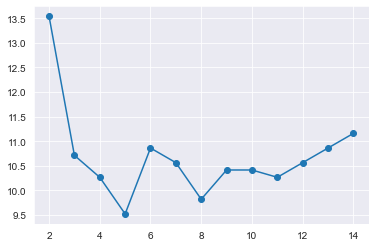

In [278]:
# 2) k-NN and evaluation
from sklearn import neighbors

# Loop on several models ! and check for which value of the hyperparameter k we get the least error percentage.
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    # We "fit" the model to our training data and compute the percentage of correct predictions with "score"
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()


In [279]:
# 3) predict !!
# We use the best classifier to predict
k = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

X_pred = zipcode_na[["Latitude", "Longitude"]] # 16 missing postal code
correct_target = np.array(right_zipcode, dtype=np.float64) # 16 correct ZipCodes / dtype so that it won't be int32

y_pred = knn.predict(X_pred)
print(y_pred)
print(correct_target)

# Accuracy of what X_pred predicted (y_pred) and correct_targer
knn.score(X_pred, correct_target)
# Accuracy 14/16 = 0.875, means two wrong predictions.

error = 1 - knn.score(X_pred, correct_target)
print('Error in prediction : %.3f' % error) # .1 means 1 decimal, .2 means 2 decimals
print('Error in prediction : {:.1%}'.format(error))

[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98102. 98122. 98118.
 98126. 98144. 98104. 98109. 98108. 98108.]
[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98112. 98122. 98118.
 98126. 98108. 98104. 98119. 98108. 98108.]
Error in prediction : 0.188
Error in prediction : 18.8%


### Filling second and third property TODO ****

In [280]:
def fill_second_third_property(data_frame, columns_to_fill):
    """

    :param data_frame:
    :param columns_to_fill:
    :return:
    """
    df = data_frame.copy()
    df = df
    pass

In [281]:
all_data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   ZipCode                          3360 non-null   float64
 5   CouncilDistrictCode              3376 non-null   int64  
 6   Latitude                         3376 non-null   float64
 7   Longitude                        3376 non-null   float64
 8   YearBuilt                        3376 non-null   int64  
 9   NumberofBuildings                3368 non-null   float64
 10  NumberofFloors                   3376 non-null   int64  
 11  PropertyGFATotal                 3376 non-null   int64  
 12  PropertyGFAParking  

In [282]:
all_data[~all_data["Outlier"].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.00000,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.00000,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.00000,Data Center,39336.00000,Parking,25000.00000,NaN,NaN,297.39999,299.20001,909.59998,911.50000,41399504.00000,41650404.00000,0.00000,11663150.00000,39794668.00000,16048.30957,1604831.00000,False,NaN,Non-Compliant,High outlier,362.66000,2.10000
384,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.00000,5335200380,4,NORTHEAST,47.66178,-122.31812,1987,1.00000,2,69492,0,69492,Retail Store,Retail Store,69800.00000,Other,0.00000,NaN,NaN,NaN,100.00000,4.60000,4.60000,14.30000,14.30000,318962.81250,318962.81250,0.00000,93482.60156,318963.00000,0.00000,0.00000,False,NaN,Non-Compliant,Low outlier,2.22000,0.03000
448,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.00000,5247800200,2,DOWNTOWN,47.59878,-122.33458,1913,5.00000,7,154159,0,154159,Office,Office,193154.00000,NaN,NaN,NaN,NaN,NaN,100.00000,58.00000,58.80000,28.00000,28.70000,11195917.00000,11348758.00000,0.00000,471503.00000,1608768.00000,3430.50049,343050.00000,False,NaN,Non-Compliant,Low outlier,29.43000,0.19000
517,704,2016,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.00000,7666202110,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.00000,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.00000,Parking,42500.00000,Data Center,4778.00000,NaN,1.00000,311.70001,311.70001,978.90002,978.90002,27137190.00000,27137190.00000,0.00000,7953454.50000,27137187.00000,0.00000,0.00000,False,NaN,Non-Compliant,High outlier,189.18000,1.46000
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,Bay Vista,2821 2nd Ave,Seattle,WA,98121.00000,0586400000,7,DOWNTOWN,47.61706,-122.35141,1982,1.00000,24,167941,0,167941,"Multifamily Housing, Swimming Pool",Multifamily Housing,138787.00000,Parking,99952.00000,Swimming Pool,0.00000,NaN,100.00000,17.30000,18.70000,50.40000,54.00000,2407904.50000,2589125.50000,0.00000,626561.62500,2137828.00000,2700.76001,270076.00000,False,NaN,Non-Compliant,Low outlier,29.25000,0.17000
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,Belmont Lofts,231 Belmont Ave E,Seattle,WA,98102.00000,0704600000,3,EAST,47.62059,-122.32440,1989,1.00000,4,31702,0,31702,"Multifamily Housing, Parking",Multifamily Housing,26418.00000,Parking,14280.00000,NaN,NaN,NaN,NaN,9.70000,10.40000,30.40000,32.70000,255971.20310,275412.00000,0.00000,75020.89844,255971.00000,0.00000,0.00000,False,NaN,Non-Compliant,Low outlier,1.78000,0.06000
839,19967,2016,SPS-District K-12,K-12 School,Queen Anne Gym,1431 2nd Ave N,Seattle,WA,98109.00000,0811000005,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1.00000,1,35805,0,35805,K-12 School,K-12 School,35805.00000,NaN,NaN,NaN,NaN,NaN,100.00000,12.10000,12.10000,27.00000,27.00000,431471.68750,431471.68750,0.00000,72282.39844,246628.00000,1848.43958,184844.00000,True,NaN,Error - Correct Default Data,Low outlier,11.54000,0.32000
962,20367,2016,Multifamily LR (1-4),Low-Rise Multifamily,City Lig